In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import pandas as pd
import numpy as np

#pre_processing
#
#
#
#
#
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')
df.head()

df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis = 1)

df_clean = df_clean_column.dropna(axis = 0)

pmmet_class = np.unique(df_clean['pmmet'])


pmmet_value = [sum(df_clean['pmmet']==pmmet_class[0]),
             sum(df_clean['pmmet']==pmmet_class[1])]

y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values
X.shape
#


(1555, 14)

In [10]:
from imblearn.over_sampling import SMOTE
######
oversample = SMOTE(sampling_strategy=1)
X,y = oversample.fit_resample(X,y)
######

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

from sklearn.decomposition import PCA
fr = PCA(n_components=3)
fr.fit(X_train)
X_test = fr.transform(X_test)
X_train = fr.transform(X_train)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [11]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from datetime import datetime
params = {
    'iterations' : [200,500],
    'depth' : [9,10,11,12],
    'learning_rate':[0.9,1],  
}
start=datetime.now()
clf = GridSearchCV(CatBoostClassifier(random_state=0,verbose=False),params, cv = 10)
clf.fit(X_train_norm, y_train)
print('best params search time: '+str(datetime.now()-start))
print("Best params : " + str(clf.best_params_))

print("10CV accuracy : "+str(clf.best_score_*100))

best params search time: 0:13:43.167577
Best params : {'depth': 12, 'iterations': 500, 'learning_rate': 1}
10CV accuracy : 79.98971783835485


In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
start = datetime.now()
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
runtime = datetime.now()-start

print('test runtime: '+ str(runtime))
sum(y_test == y_predict)/len(y_test)

test runtime: 0:00:00.003065


0.81640625

In [13]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.82      0.81      0.81       257
    positive       0.81      0.83      0.82       255

    accuracy                           0.82       512
   macro avg       0.82      0.82      0.82       512
weighted avg       0.82      0.82      0.82       512



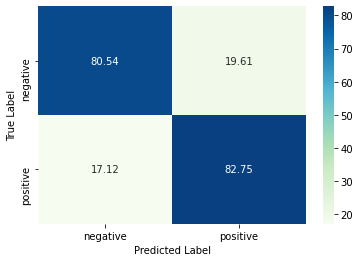

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()